In [ ]:
pip install adversarial-robustness-toolbox

In [ ]:
pip install git+https://github.com/nottombrown/imagenet_stubs

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-6figdc_j
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-6figdc_j
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-cp37-none-any.whl size=794842 sha256=8e736aae0dfbdaab6d602dfffc6b730cba5d8eb25b941c079d0ca3ea2e8d9079
  Stored in directory: /tmp/pip-ephem-wheel-cache-b9l0621h/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs


## ***Loading Libraries*** 

In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input 
from keras.preprocessing import image

# Load ART dependencies:
from art.estimators.classification import KerasClassifier

# Attacks 
from art.attacks.evasion import ZooAttack
from art.attacks.evasion import SquareAttack 
from art.attacks.evasion import NewtonFool 
from art.attacks.evasion import PixelAttack
from art.attacks.evasion import ThresholdAttack

In [ ]:
import numpy as np
from datetime import datetime 
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Install ImageNet stubs:
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

In [ ]:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

tf.compat.v1.experimental.output_all_intermediates(True) 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## ***Loading Images***

In [ ]:
images_list = list()
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    images_list.append(im)
    print (image_path)
    if 'koala.jpg' in image_path:
        # get gazelle index
        koala_idx = i
images = np.array(images_list)

/usr/local/lib/python3.7/dist-packages/imagenet_stubs/images/gazelle.jpg
/usr/local/lib/python3.7/dist-packages/imagenet_stubs/images/sleeping_bag.jpg
/usr/local/lib/python3.7/dist-packages/imagenet_stubs/images/malamute.jpg
/usr/local/lib/python3.7/dist-packages/imagenet_stubs/images/manhole_cover.jpg
/usr/local/lib/python3.7/dist-packages/imagenet_stubs/images/standard_poodle.jpg
/usr/local/lib/python3.7/dist-packages/imagenet_stubs/images/bagel.jpg
/usr/local/lib/python3.7/dist-packages/imagenet_stubs/images/koala.jpg
/usr/local/lib/python3.7/dist-packages/imagenet_stubs/images/rock_crab.jpg
/usr/local/lib/python3.7/dist-packages/imagenet_stubs/images/marmoset.jpg
/usr/local/lib/python3.7/dist-packages/imagenet_stubs/images/flagpole.jpg
/usr/local/lib/python3.7/dist-packages/imagenet_stubs/images/mitten.jpg
/usr/local/lib/python3.7/dist-packages/imagenet_stubs/images/unicycle.jpg
/usr/local/lib/python3.7/dist-packages/imagenet_stubs/images/tractor.jpg
/usr/local/lib/python3.7/dist-p

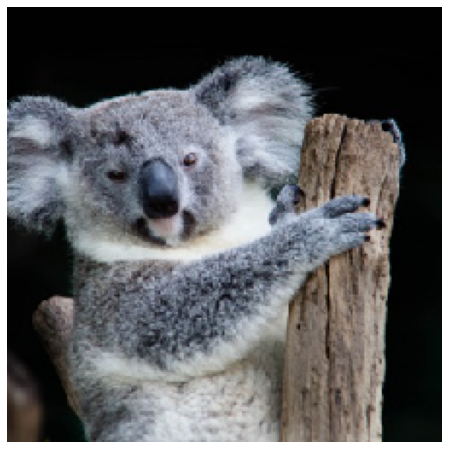

In [ ]:
idx = koala_idx

plt.figure(figsize=(8,8)); plt.imshow(images[idx] / 255); plt.axis('off'); plt.show()

## ***Loading ResNet50*** 

In [ ]:
# This loads the pretrained ResNet50 model:
model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# We need to expand the input dimension and apply the preprocessing required for ResNet50:
x = np.expand_dims(images[idx].copy(), axis=0)
x = preprocess_input(x)

# Then apply the model, determine the predicted label and confidence:
pred = model.predict(x)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00


In [ ]:
from art.preprocessing.preprocessing import Preprocessor

class ResNet50Preprocessor(Preprocessor):

    def __call__(self, x, y=None):
        return preprocess_input(x.copy()), y

    def estimate_gradient(self, x, gradient):
        return gradient[..., ::-1]

In [ ]:
# Create the ART preprocessor and classifier wrapper:
preprocessor = ResNet50Preprocessor()
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=preprocessor)

In [ ]:
# Same as for the original model, we expand the dimension of the inputs.
x_art = np.expand_dims(images[idx], axis=0) 

# Then apply the model through the classifier API, determine the predicted label and confidence:
pred = classifier.predict(x_art)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00


## ***Attacking***

### **Zoo Attack**

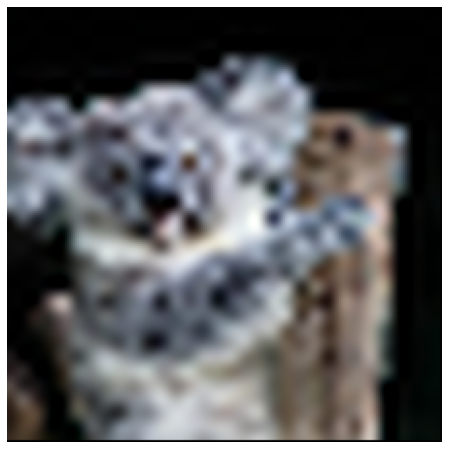

Prediction: hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa - confidence 0.55


In [ ]:
adv = ZooAttack(classifier=classifier)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

### **Square Attacks** 

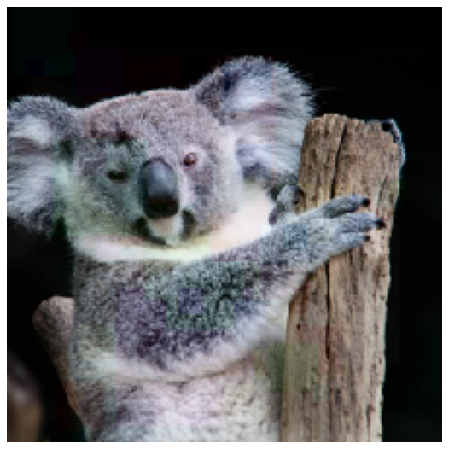

Prediction: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 0.96


In [ ]:
start = datetime.now()  
adv = SquareAttack(estimator=classifier, eps=5)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

print("Computing time takes %s" %(datetime.now()-start))

### **NewtonFool**

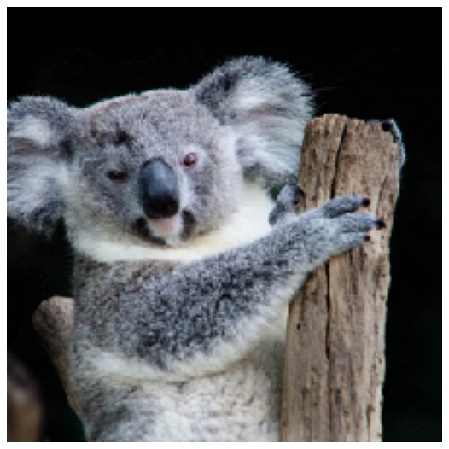

Prediction: mink - confidence 0.30
Computing time takes 0:00:52.932043


In [ ]:
start = datetime.now()  
adv = NewtonFool(classifier=classifier)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

print("Computing time takes %s" %(datetime.now()-start))

### ***Universal Perturbation Attack***

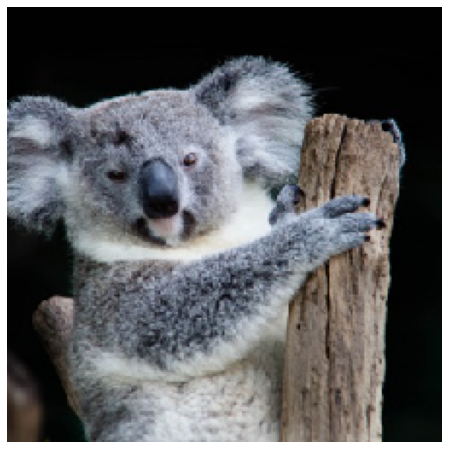

Prediction: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00
Computing time takes 0:13:46.831112


In [ ]:
from art.attacks.evasion import UniversalPerturbation


start = datetime.now()  
adv = UniversalPerturbation(classifier=classifier, attacker = 'pgd')

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

print("Computing time takes %s" %(datetime.now()-start))

### ***Elasticnet*** 

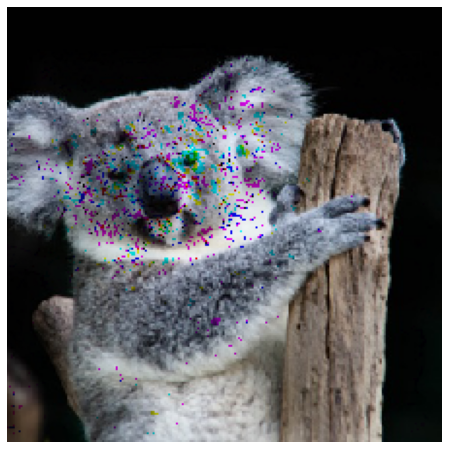

Prediction: mitten - confidence 0.55
Computing time takes 0:35:52.237157


In [ ]:
from art.attacks.evasion import ElasticNet

start = datetime.now()  
adv = ElasticNet(classifier=classifier, max_iter=200)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

print("Computing time takes %s" %(datetime.now()-start))

Computing time takes 0:35:52.237157


In [ ]:
from art.defences.preprocessor import SpatialSmoothing
from art.defences.preprocessor import FeatureSqueezing
from art.defences.preprocessor import GaussianAugmentation

gda = GaussianAugmentation(sigma=6, augmentation=False) # Strength = high (sigma=9), middle (sigma=6), low (sigma=3) 
ss = SpatialSmoothing(window_size=3) # Strength = low (3), middle = 5, 


x_art_adv_ss_def, _ = ss(x_art_adv)
x_art_adv_ss_gda_def, _ = gda(x_art_adv_ss_def)

pred_adv_ss_gda_def = classifier.predict(x_art_adv_ss_gda_def)
label_adv_ss_gda_def = np.argmax(pred_adv_ss_gda_def, axis=1)[0]
confidence_adv_ss_gda_def = pred_adv_ss_gda_def[:, label_adv_ss_gda_def][0]

print('Prediction of adversarial sample:', label_to_name(label_adv_ss_gda_def), 
      '- confidence {0:.2f}'.format(confidence_adv_ss_gda_def))

Prediction of adversarial sample: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 0.26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


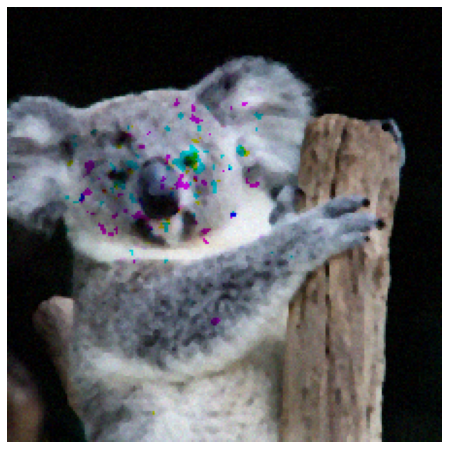

In [ ]:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_ss_gda_def[0] / 255); plt.axis('off'); plt.show()

### ***SimBA***

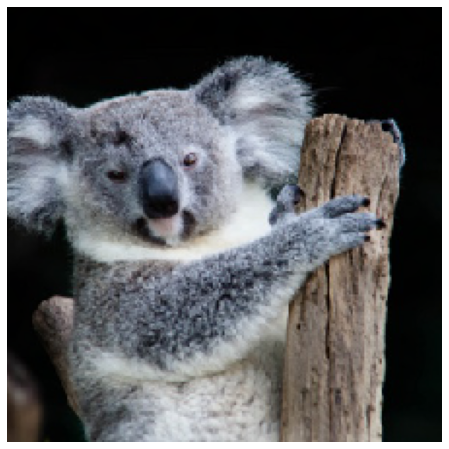

Prediction: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00
Computing time takes 0:13:53.118934


In [ ]:
from art.attacks.evasion import SimBA

start = datetime.now()  
adv = SimBA(classifier =classifier)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

print("Computing time takes %s" %(datetime.now()-start))

### ***Feature Adversaries***

In [ ]:
from art.attacks.evasion import FeatureAdversaries

start = datetime.now()  
adv = FeatureAdversaries(classifier =classifier)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

print("Computing time takes %s" %(datetime.now()-start))

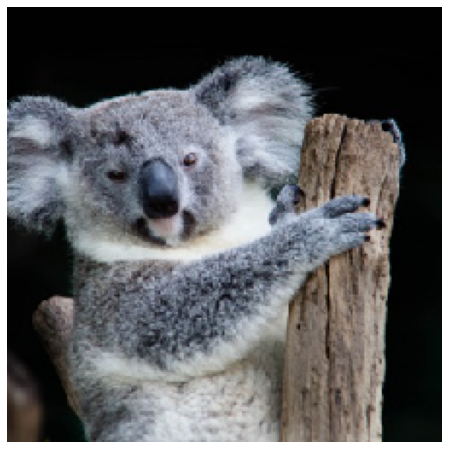

Prediction: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00
Computing time takes 1:32:51.626372


In [ ]:
from art.attacks.evasion import SpatialTransformation

start = datetime.now()  
adv = SpatialTransformation(classifier = classifier, max_translation = 10,  num_translations = 10, max_rotation=10, num_rotations=100)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

print("Computing time takes %s" %(datetime.now()-start))

## Carlini and Wagner L_2 Attack

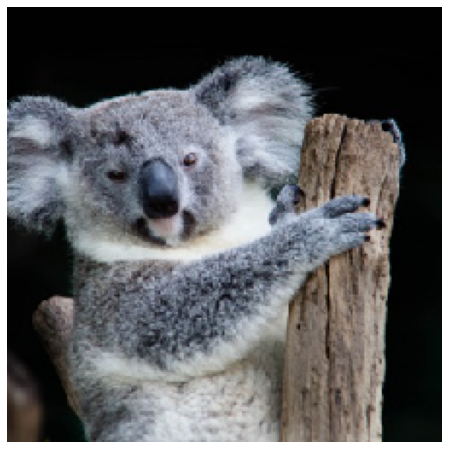

Prediction: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00
Computing time takes 0:02:01.560397


In [ ]:
from art.attacks.evasion import CarliniLInfMethod

start = datetime.now()  
adv = CarliniLInfMethod(classifier = classifier, eps=10, max_iter=50, max_halving=10)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

print("Computing time takes %s" %(datetime.now()-start))

## ***HopSkipJump Untargeted Attack***

Target image is:  105


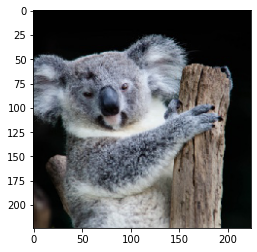

In [ ]:
target_image_name = 'koala.jpg'
for image_path in imagenet_stubs.get_image_paths():
    if image_path.endswith(target_image_name):
        target_image = image.load_img(image_path, target_size=(224, 224))
        target_image = image.img_to_array(target_image)
        
print("Target image is: ", np.argmax(classifier.predict(np.array([target_image]))[0]))
plt.imshow(target_image.astype(np.uint))
plt.show()


Adversarial image at step 0. L2 error 13792.451 and class label 359.
Prediction: black-footed ferret, ferret, Mustela nigripes - confidence 0.32


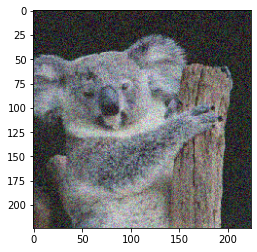


Adversarial image at step 10. L2 error 8900.068 and class label 359.
Prediction: black-footed ferret, ferret, Mustela nigripes - confidence 0.81


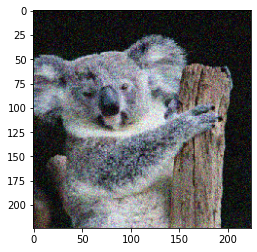


Adversarial image at step 20. L2 error 6562.3774 and class label 359.
Prediction: black-footed ferret, ferret, Mustela nigripes - confidence 0.75


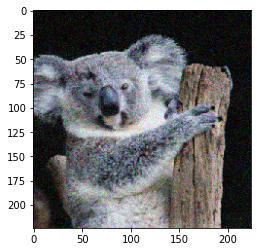


Adversarial image at step 30. L2 error 5126.842 and class label 359.
Prediction: black-footed ferret, ferret, Mustela nigripes - confidence 0.54


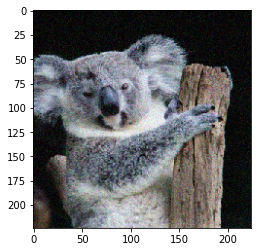


Adversarial image at step 40. L2 error 4138.563 and class label 359.
Prediction: black-footed ferret, ferret, Mustela nigripes - confidence 0.42


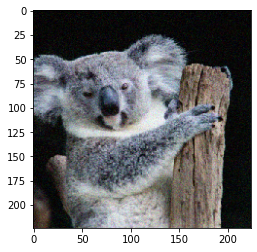


Adversarial image at step 50. L2 error 3492.821 and class label 359.
Prediction: black-footed ferret, ferret, Mustela nigripes - confidence 0.42


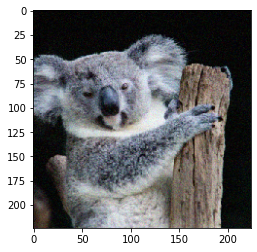


Adversarial image at step 60. L2 error 2929.2397 and class label 359.
Prediction: black-footed ferret, ferret, Mustela nigripes - confidence 0.33


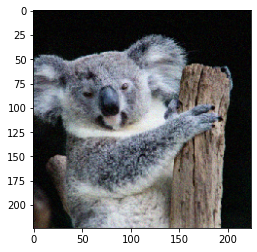


Adversarial image at step 70. L2 error 2447.2532 and class label 356.
Prediction: weasel - confidence 0.39


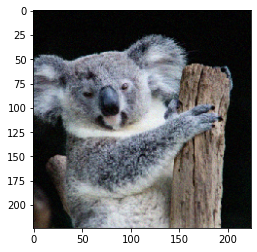


Adversarial image at step 80. L2 error 2088.2905 and class label 356.
Prediction: weasel - confidence 0.42


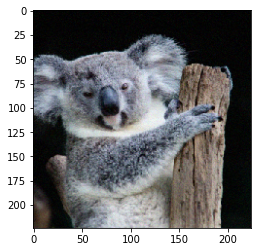


Adversarial image at step 90. L2 error 1800.9753 and class label 356.
Prediction: weasel - confidence 0.41


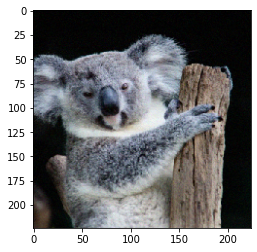


Adversarial image at step 100. L2 error 1599.2079 and class label 356.
Prediction: weasel - confidence 0.40


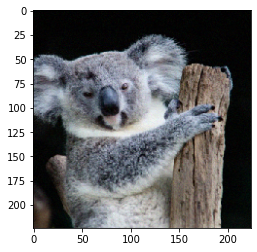


Adversarial image at step 110. L2 error 1423.8523 and class label 356.
Prediction: weasel - confidence 0.39


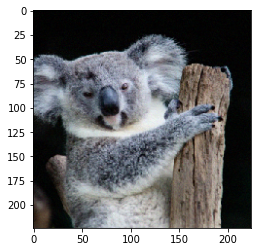


Adversarial image at step 120. L2 error 1279.0459 and class label 356.
Prediction: weasel - confidence 0.39


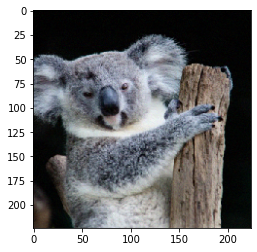


Adversarial image at step 130. L2 error 1153.4513 and class label 356.
Prediction: weasel - confidence 0.40


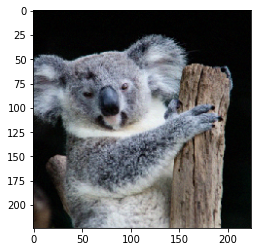


Adversarial image at step 140. L2 error 1041.9266 and class label 356.
Prediction: weasel - confidence 0.40


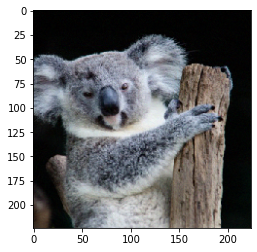


Adversarial image at step 150. L2 error 950.24286 and class label 356.
Prediction: weasel - confidence 0.40


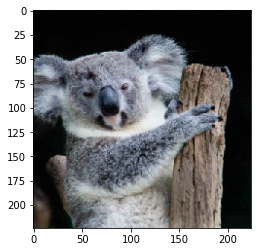


Adversarial image at step 160. L2 error 876.06934 and class label 356.
Prediction: weasel - confidence 0.40


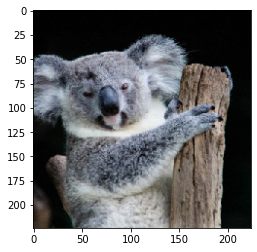


Adversarial image at step 170. L2 error 811.00494 and class label 356.
Prediction: weasel - confidence 0.40


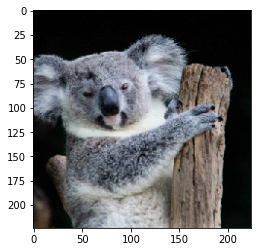


Adversarial image at step 180. L2 error 756.0915 and class label 356.
Prediction: weasel - confidence 0.39


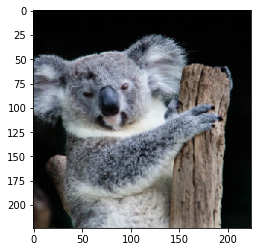


Adversarial image at step 190. L2 error 705.8046 and class label 356.
Prediction: weasel - confidence 0.40


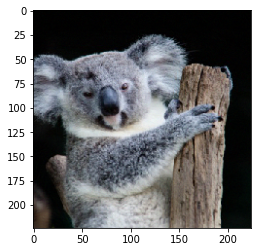

Computing time takes 0:43:26.208175


In [ ]:
from art.attacks.evasion import HopSkipJump
start = datetime.now() 

attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = None

anv_list = []

for i in range(20):
    x_adv = attack.generate(x=np.array([target_image]), x_adv_init=x_adv, resume=True)
    anv_list.append(x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    
    # And apply the classifier to it:
    pred_adv = classifier.predict(x_adv)
    label_adv = np.argmax(pred_adv, axis=1)[0]
    confidence_adv = pred_adv[:, label_adv][0]
    print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))
    
    plt.imshow(x_adv[0].astype(np.uint))
    plt.show(block=False)
    
    attack.max_iter = iter_step

print("Computing time takes %s" %(datetime.now()-start))

Computing time takes 0:43:26.208175

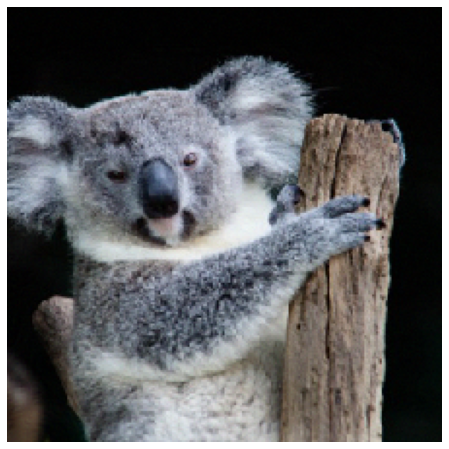

In [ ]:
plt.figure(figsize=(8,8)); plt.imshow(anv_list[19][0] / 255); plt.axis('off'); plt.show()

In [ ]:
pred_adv = classifier.predict(anv_list[19])
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

Prediction: weasel - confidence 0.40


In [ ]:
from art.defences.preprocessor import SpatialSmoothing
from art.defences.preprocessor import FeatureSqueezing
from art.defences.preprocessor import GaussianAugmentation

gda = GaussianAugmentation(sigma=3, augmentation=False) # Strength = high (sigma=9), middle (sigma=6), low (sigma=3) 
ss = SpatialSmoothing(window_size=1) # Strength = low (3), middle = 5, 


x_art_adv_ss_def, _ = ss(anv_list[19])
x_art_adv_ss_gda_def, _ = gda(x_art_adv_ss_def)

pred_adv_ss_gda_def = classifier.predict(x_art_adv_ss_gda_def)
label_adv_ss_gda_def = np.argmax(pred_adv_ss_gda_def, axis=1)[0]
confidence_adv_ss_gda_def = pred_adv_ss_gda_def[:, label_adv_ss_gda_def][0]

print('Prediction of adversarial sample:', label_to_name(label_adv_ss_gda_def), 
      '- confidence {0:.2f}'.format(confidence_adv_ss_gda_def))

Prediction of adversarial sample: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 0.97


New 
## ***CW Attack***

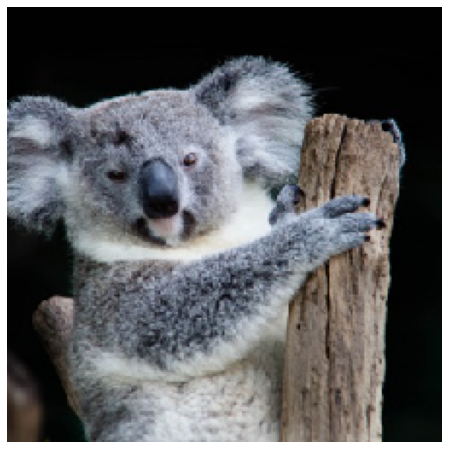

Prediction: koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus - confidence 1.00
Computing time takes 0:33:10.171414


In [ ]:
from art.attacks.evasion import CarliniL2Method

start = datetime.now()  
adv = CarliniL2Method(classifier = classifier,  initial_const=10, binary_search_steps=25, max_iter=50, confidence=5) # targeted=True 
# y = to_categorical(71, 1000) # scorpion 

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)  ## y=(71, 999) 

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

print("Computing time takes %s" %(datetime.now()-start))